Run 2: Using the topic_distribution and topic labels generated from running across 45 topics across all 9k documents


In [ ]:
pip install -U spacy


In [ ]:
pip install transformers spacy-transformers


Retrieve top ten topics

In [3]:

import json

# Open the JSON file and load it into a variable
with open('topic_distribution_test.json', 'r') as file:
    topic_distribution = json.load(file)

# Sort the dictionary by values (topic scores) in descending order
sorted_topics = sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 topics
top_ten_topics = [topic for topic, value in sorted_topics[:10]]

print(top_ten_topics)

['Case Analysis and Legal Strategies', 'Legal Procedures and Criminal Cases', 'Judicial Decision-Making and Legal Parties', 'Legal Outcomes and Accusations', 'Legal Evidence and Case Outcomes', 'Evidence and Judicial Considerations', 'Appellate Court Focus', 'Costs and Parties in Appeal', 'Evidence and Appeal in Legal Proceedings', 'First Instance Legal Decisions']


Load document-topic assignment

In [4]:

with open('labeled_document_topic_test.json', 'r') as file:
    document_topic = json.load(file)

# Step 3: Organize documents under their respective top ten topics
topics_documents = {topic: [] for topic in top_ten_topics}  # Initialize a dictionary for the top ten topics

for doc_id, topic in document_topic.items():
    if topic in top_ten_topics:
        topics_documents[topic].append(doc_id)  # Add document under its topic

# Print the categorized documents
for topic, docs in topics_documents.items():
    print(f"{topic}: {docs}")

Case Analysis and Legal Strategies: ['Document 12', 'Document 24', 'Document 53', 'Document 125', 'Document 171', 'Document 176', 'Document 182', 'Document 262', 'Document 288', 'Document 308', 'Document 309', 'Document 339', 'Document 421', 'Document 477', 'Document 516', 'Document 519', 'Document 520', 'Document 521', 'Document 614', 'Document 620', 'Document 626', 'Document 630', 'Document 633', 'Document 646', 'Document 686', 'Document 751', 'Document 782', 'Document 800', 'Document 822', 'Document 832', 'Document 840', 'Document 855', 'Document 856', 'Document 890', 'Document 948', 'Document 951', 'Document 962', 'Document 985', 'Document 1061', 'Document 1088', 'Document 1091', 'Document 1096', 'Document 1100', 'Document 1118', 'Document 1169', 'Document 1170', 'Document 1198', 'Document 1246', 'Document 1295', 'Document 1309', 'Document 1320', 'Document 1451', 'Document 1453', 'Document 1472', 'Document 1519', 'Document 1534', 'Document 1559', 'Document 1590', 'Document 1593', '

In [5]:
import pandas as pd
import spacy
import spacy_transformers

# Load the CSV file
df = pd.read_csv("../sectionized_data.csv")
df = df.dropna()

# Load the NER file
ner_model_path = '../model_ner'
nlp = spacy.load(ner_model_path)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_legal_ner_trf' (3.2.0) was trained with spaCy v3.2.2 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, dow

In [6]:
from collections import Counter

def get_document_text(doc_id):  
    index = int(doc_id.split(' ')[1]) 
    return df.iloc[index]['Body']

EXTRACTING ONLY THE COURT LABEL

In [8]:
all_topics_output = []

for top_topic in top_ten_topics:
    court_entities = []
    for doc_id in topics_documents[top_topic]:
        doc_text = get_document_text(doc_id)
        doc = nlp(doc_text)
        court_entities.extend([ent.text for ent in doc.ents if ent.label_ == "COURT"])

    # Find the most frequently occurring entities for the current topic
    court_entities_counts = Counter(court_entities)
    if court_entities_counts:
        max_count = max(court_entities_counts.values())
        # Keep only entities with the highest count
        most_frequent_entities = {entity: count for entity, count in court_entities_counts.items() if count == max_count}
    else:
        most_frequent_entities = {}

    # Append to the overall output
    all_topics_output.append({
        "Topic": top_topic,
        "Most Frequent COURT Entities": most_frequent_entities
    })

# Format for output
output_structure = {
    "Topics": all_topics_output
}

output_file_path = 'top_ten_topics_most_frequent_court_entities.json'

# Write the formatted data to a JSON file
with open(output_file_path, 'w') as file:
    json.dump(output_structure, file, indent=2)

print(f"Data written to {output_file_path}")


Data written to top_ten_topics_most_frequent_court_entities.json


In [9]:
input_file_path = 'top_ten_topics_most_frequent_court_entities.json'

# Load the JSON data from the file
with open(input_file_path, 'r') as file:
    data = json.load(file)

print("Top COURT Entities for the top ten topics")

for topic_info in data["Topics"]:
    topic_name = topic_info["Topic"]
    entities = list(topic_info["Most Frequent COURT Entities"].keys())
    entities_str = ', '.join(entities)
    print(f"{topic_name}: [{entities_str}]")


Top COURT Entities for the top ten topics
Case Analysis and Legal Strategies: [Supreme Court]
Legal Procedures and Criminal Cases: [Supreme Court]
Judicial Decision-Making and Legal Parties: [Supreme Court]
Legal Outcomes and Accusations: [Supreme Court]
Legal Evidence and Case Outcomes: [Supreme Court]
Evidence and Judicial Considerations: [Supreme Court]
Appellate Court Focus: [Supreme Court]
Costs and Parties in Appeal: [Supreme Court]
Evidence and Appeal in Legal Proceedings: [Supreme Court]
First Instance Legal Decisions: [Syariah Court]


EXTRACT ACROSS ALL NER LEGAL ENTITIES

In [10]:
all_topics_output_for_all_entities = []

specified_labels = ["PRECEDENT", "LAWYER", "JUDGE", "RESPONDENT", "GPE",
                    "OTHER_PERSON", "PROVISION", "ORG", "PETITIONER",
                    "WITNESS", "COURT", "STATUTE"]

for top_topic in top_ten_topics:
    entities_by_label = {label: [] for label in specified_labels}
    for doc_id in topics_documents[top_topic]:
        doc_text = get_document_text(doc_id)
        doc = nlp(doc_text)
        for ent in doc.ents:
            if ent.label_ in specified_labels:
                entities_by_label[ent.label_].append(ent.text)
    
    most_frequent_entities_by_label = {
        label: Counter(entities).most_common(1) for label, entities in entities_by_label.items() if entities
    }

    all_topics_output_for_all_entities.append({
        "Topic": top_topic,
        "Most Frequent Entities by Label": most_frequent_entities_by_label
    })

output_structure = {
    "Topics": all_topics_output_for_all_entities
}

output_file_path = 'top_ten_topics_most_frequent_entities_by_label.json'

with open(output_file_path, 'w') as file:
    json.dump(output_structure, file, indent=2)

print(f"Data written to {output_file_path}")

Data written to top_ten_topics_most_frequent_entities_by_label.json


In [11]:
all_entities_input_file_path = 'top_ten_topics_most_frequent_entities_by_label.json'

with open(all_entities_input_file_path, 'r') as file:
    data = json.load(file)

print("Top Entities by Specified Labels for the Top Ten Topics")

for topic_info in data["Topics"]:
    topic_name = topic_info["Topic"]
    print(f"\n{topic_name}:")
    for label, entities in topic_info["Most Frequent Entities by Label"].items():
        entities_str = ', '.join([f"{ent[0]} ({ent[1]})" for ent in entities])
        print(f"  {label}: {entities_str}")

Top Entities by Specified Labels for the Top Ten Topics

Case Analysis and Legal Strategies:
  PRECEDENT: Ladd v Marshall (30)
  LAWYER: Davinder Singh (15)
  JUDGE: Judith Prakash (90)
  RESPONDENT: Government of Singapore (8)
  GPE: Singapore (3212)
  OTHER_PERSON: Tan (1270)
  PROVISION: s 18(2) (115)
  ORG: Parliament (360)
  PETITIONER: Goh (8)
  WITNESS: Tan (30)
  COURT: Supreme Court (102)
  STATUTE: CPC (409)

Legal Procedures and Criminal Cases:
  PRECEDENT: Birkett v James (18)
  LAWYER: Davinder Singh (11)
  JUDGE: Judith Prakash (81)
  RESPONDENT: Tian E Zuo (8)
  GPE: Singapore (2923)
  OTHER_PERSON: Tan (961)
  PROVISION: s 377A (93)
  ORG: Government of Singapore (289)
  PETITIONER: NKY (7)
  WITNESS: Lim (43)
  COURT: Supreme Court (104)
  STATUTE: CPC (302)

Judicial Decision-Making and Legal Parties:
  PRECEDENT: Ladd v Marshall (20)
  LAWYER: Alex Chew (16)
  JUDGE: Chao Hick Tin (73)
  RESPONDENT: Government of Singapore (5)
  GPE: Singapore (2433)
  OTHER_PERSON: 

Save it into a json file


In [12]:

# Initialize a list to hold the formatted data
formatted_data = []

for topic_info in data["Topics"]:
    topic_name = topic_info["Topic"]
    topic_dict = {"Topic": topic_name, "Entities": {}}
    
    for label, entities in topic_info["Most Frequent Entities by Label"].items():
        # Create a string representation for each entity and its count
        entities_dict = {ent[0]: ent[1] for ent in entities}
        topic_dict["Entities"][label] = entities_dict
    
    formatted_data.append(topic_dict)

# Specify the new output file path for the formatted data
output_file_path = 'formatted_top_ten_topics_most_frequent_entities_by_label.json'

# Write the formatted data to a JSON file
with open(output_file_path, 'w') as file:
    json.dump(formatted_data, file, indent=2)

print(f"Data written to {output_file_path}")


Data written to formatted_top_ten_topics_most_frequent_entities_by_label.json


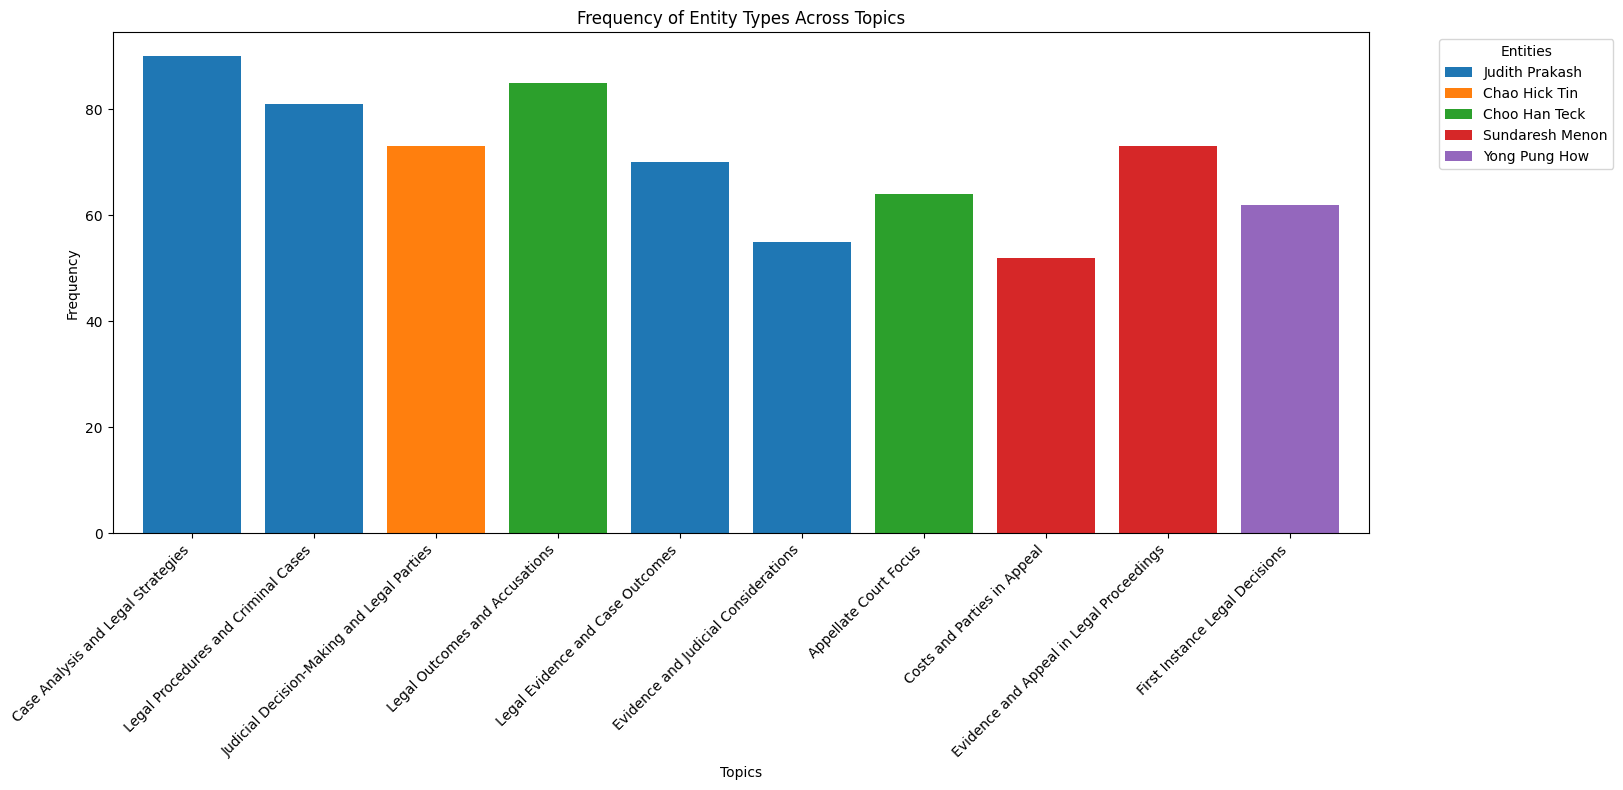

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import json

formatted_all_entities_file_path = 'formatted_top_ten_topics_most_frequent_entities_by_label.json'

with open(formatted_all_entities_file_path, 'r') as file:
    data_json = json.load(file)

# Function to aggregate entity frequencies across topics for a specified entity type
def aggregate_entities(data_json, entity_type):
    topics = []
    entity_aggregation = {}
    
    for topic_info in data_json:
        topic = topic_info['Topic']
        topics.append(topic)
        entities = topic_info['Entities'].get(entity_type, {})
        
        for entity, frequency in entities.items():
            if entity not in entity_aggregation:
                entity_aggregation[entity] = [0] * len(data_json)
            entity_aggregation[entity][topics.index(topic)] = frequency
            
    return topics, entity_aggregation

# Function to plot all entities of a type across all topics in one graph
def plot_aggregated_entities(topics, entity_aggregation):
    # Creating a DataFrame from the aggregated data
    df = pd.DataFrame(entity_aggregation, index=topics)
    
    # Plot
    ax = df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8)
    ax.set_title("Frequency of Entity Types Across Topics")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Topics")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.legend(title="Entities", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

entity_type = 'JUDGE'  # others: ORG, COURT

topics, entity_aggregation = aggregate_entities(data_json, entity_type)
plot_aggregated_entities(topics, entity_aggregation)
plt.show()